| [![View in NeuroAIKit Documentation](../_static/toolkit_32px.png)](https://ibm.github.io/neuroaikit/Examples/JSB.html) |  [![View source on GitHub](../_static/github_32px.png)](https://github.com/IBM/neuroaikit/blob/main/Website/Examples/JSB.ipynb) |
| - | - |
| View in NeuroAIKit Documentation | View source on GitHub |

# Music prediction (JSB)

This tutorial shows how to:

1. Interpret musical notes as a temporal stream of spikes, where the location in time matters (temporal coding).
1. Build a spiking network that predicts the next musical chord based on the chords seen so far.
1. Generate and play an entire song based on one-step predictions.

## Musical notes as spikes

A presence of a particular sound at a particular time location is what creates music, and what the common musical notation conveys through musical sheets. Alternatively, we can view the information on the presence of sounds or musical notes as spikes.

A typical piano keyboard has 88 keys [(Wikimedia - Creative Commons)](https://commons.wikimedia.org/wiki/File:Piano_Keyboard_Diagram.svg):

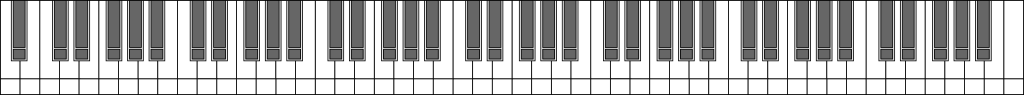

Therefore, for each timestep of a muscial piece, we can encode the information of the musical notes played by sending spikes to an input layer with 88 inputs. For illustration, let's use the JSB dataset from N. Boulanger-Lewandowski, et al., ICML 2012, that comprises chorales written by Johann Sebastian Bach. It can be loaded as follows:

In [1]:
import neuroaikit.dataset.datasets as aid
x = aid.JSB()

The tuple `x` contains the data split into: 229 train, 76 validation, and 77 test chorales: 

In [2]:
len(x), len(x[0]), len(x[1]), len(x[2])

(3, 229, 76, 77)

Each music piece is a sequence of 88-dimensional vectors. The first training chorales is 129 time steps long:

In [3]:
x[0][0].shape

(129, 88)

We can visualize the first 20 time steps of this chorales as spikes. Note that the most commonly used notes are in the center of the keyboard and the y axis is automatically cropped:

Text(0, 0.5, 'Input index')

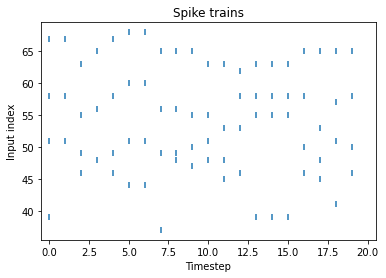

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(*np.where(x[0][0][0:20,:]), marker='|')
plt.title('Spike trains')
plt.xlabel('Timestep')
plt.xlim([-0.5,20.5])
#plt.ylim([0,88])
plt.ylabel('Input index')

## Train a network

Based on the input spikes observed at 88 inputs, we can build a network that would output notes' predictions. In such case, the last layer should also have 88 outputs, as illustrated below:

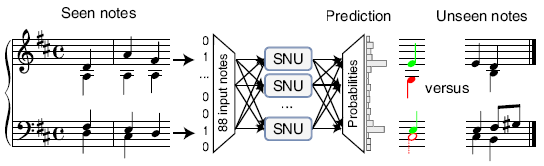

Let's import the required modules and build the network:

In [5]:
import neuroaikit as ai
import neuroaikit.tf as aitf
import tensorflow as tf

The network includes one hidden layer of spiking neurons and a dense output layer without activation that outputs the raw logits:

In [19]:
config = {'decay': 0.8, 'g': aitf.activations.leaky_rel}

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 88]))
model.add(aitf.layers.SNU(150, **config, return_sequences=True))
model.add(tf.keras.layers.Dense(88)) #output logits

Then, we use the binary cross-entropy loss, that is appropriate for training our model that outputs a series of separate per-note probabilities. The loss is configured to operate on raw logits:

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=[])

For training, we need to have pairs of input and output vectors. We create a dataset generator, whose final step is to copy the input vectors twice with a shift of one timestep:

In [8]:
ds = tf.data.Dataset.from_generator(lambda: x[0], tf.int32, output_shapes=[None,None])
ds = ds.map(lambda x: (tf.expand_dims(x[0:-1,:],0), tf.expand_dims(x[1:,:],0)))

Thus, the dataset generator returns pairs of sequences with 88 features:

In [9]:
example = ds.as_numpy_iterator()
example_x, example_y = example.next()
example_x.shape, example_y.shape

((1, 128, 88), (1, 128, 88))

Let's train the model for 40 epochs:

In [21]:
import time
time_start = time.time()
model.fit(ds, epochs=40)
print('Finished. Total time: {0:.1f} [s]'.format(time.time() - time_start))

Epoch 1/40
229/229 [==============================] - 3s 10ms/step - loss: 0.1430
Epoch 2/40
229/229 [==============================] - 2s 10ms/step - loss: 0.1074
Epoch 3/40
229/229 [==============================] - 2s 10ms/step - loss: 0.1038
Epoch 4/40
229/229 [==============================] - 2s 10ms/step - loss: 0.1021
Epoch 5/40
229/229 [==============================] - 2s 11ms/step - loss: 0.1008
Epoch 6/40
229/229 [==============================] - 3s 11ms/step - loss: 0.0995
Epoch 7/40
229/229 [==============================] - 3s 11ms/step - loss: 0.0988
Epoch 8/40
229/229 [==============================] - 3s 12ms/step - loss: 0.0982: 0
Epoch 9/40
229/229 [==============================] - 2s 11ms/step - loss: 0.0974
Epoch 10/40
229/229 [==============================] - 3s 11ms/step - loss: 0.0968
Epoch 11/40
229/229 [==============================] - 3s 13ms/step - loss: 0.0964
Epoch 12/40
229/229 [==============================] - 3s 12ms/step - loss: 0.0960
Epoch 13/4

We see that the loss keeps on decreasing, which means that the model is improving. 

The accuracy of notes' predictions for neural networks is commonly assesed using the loss value of the avergage negative log-likelihood (the lower the better). SNU-based networks predict the notes quite well, as illustrated in the figure below taken from [S.Woźniak, et al., 2020](https://www.nature.com/articles/s42256-020-0187-0), where more detailed explanations are provided. Please note that the loss reported in the figure involves an averaging approach that is different from the one used in the example above, and thus the loss values are not directly comparable.

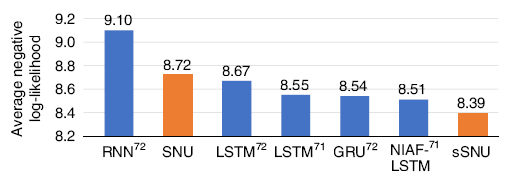

## Play one-step predictions

It's interesting to hear what are the predictions of the network. We can take the output logits and threshold them to obtain the predicted notes. Then, we can play these notes.

To play the notes, we will make use of the fact that a note is charaterized by frequency:

$f(n) = 2^{\frac{n-49}{12}} \times 440$ [Hz] - see https://en.wikipedia.org/wiki/Piano_key_frequencies

so that we can write a simple sine-wave-based synthesizer to play the music:

In [22]:
from IPython.display import Audio

def play(song, note=0.25, rate=44100):
    t = np.linspace(0, note, int(rate * note))
    data = []
    for s in range(song.shape[0]):
        val = np.zeros_like(t)
        for n in np.where(song[s,:] == 1)[0]:
            f = 2**((n-49)/12) * 440
            #val += np.sin(2 * np.pi * f * t) # "sine" sound
            val += np.clip(2*np.sin(2 * np.pi * f * t),0,1) #"organ" sound
        val *= np.clip(30.0*np.sin(np.pi * t/note), 0.0, 1.0) #smoothen to avoid 'cracks'
        data.append(val)
    return Audio(np.hstack(data), rate=rate, autoplay=True)

Let's calculate the model next-step prediction's for the 10th song and play them:

In [28]:
logits = model.predict(np.expand_dims(x[0][10],0))
notes = (logits > 0)*1
play(notes[0,0:30,:])

Here is the original:

In [27]:
play(x[0][10][0:30,:])

For comparison, predictions from an untrained model:

In [30]:
config = {'decay': 0.8, 'g': aitf.activations.leaky_rel}
untrained_model = tf.keras.Sequential()
untrained_model.add(tf.keras.layers.InputLayer(input_shape=[None, 88]))
untrained_model.add(aitf.layers.SNU(150, **config, return_sequences=True))
untrained_model.add(tf.keras.layers.Dense(88)) #output logits

logits = untrained_model.predict(np.expand_dims(x[0][10],0))
notes = (logits > 0)*1
play(notes[0,0:30,:])

The original sounds the best, which shows that music prediction is challenging in general. In comparison to an untrained model, the trained one captures some musical concepts.